In [80]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.visualization import plot_histogram
from qiskit.algorithms.optimizers import COBYLA

from qiskit import *
import qiskit.quantum_info as qi
from qiskit.tools.visualization import plot_histogram
from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import *
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
pi = math.pi

## Depolarizing noise

Here we are only considering the ideal case where the noise is only present for the delay operation.

In [81]:
noise_model = NoiseModel()

p_err = 0.02
error_1q = depolarizing_error(p_err,1) # 1 qubit depolarizing error
noise_model.add_all_qubit_quantum_error(error_1q, ['delay']) 

backend = AerSimulator(noise_model=noise_model)

Preparing the circuit with $|Ψ_{in}⟩ = U_{prep}|0⟩^{⊗n}$ here $θ = \frac{\pi}{2}$

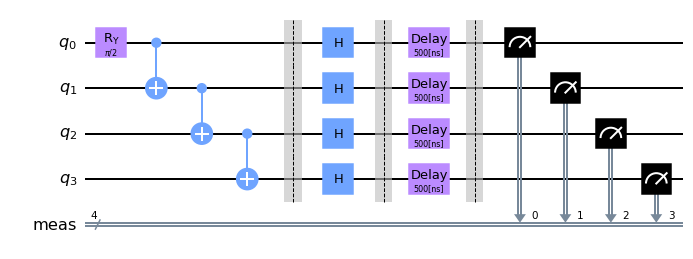

In [82]:
def U_prep(n_qubits,theta):
  qc = QuantumCircuit(n_qubits)
  qc.ry(theta,0)
  for qubit in range(n_qubits-1):
    qc.cx(qubit,qubit+1)
  qc.barrier()
  for qubit in range(n_qubits):
    qc.h(qubit)
  qc.barrier()
  return qc

qc_without_hadamard = U_prep(4,pi/2)
qc_without_hadamard.delay(500,unit='ns')
qc_without_hadamard.measure_all()
qc_without_hadamard.draw('mpl')

### Backend without noise

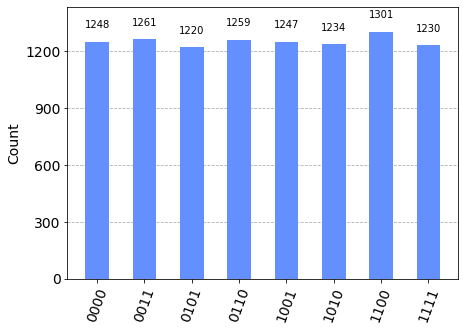

In [83]:
results_ideal = AerSimulator().run(qc_without_hadamard,shots=10000).result()
counts_ideal = results_ideal.get_counts()
plot_histogram(counts_ideal)


### This is our ground truth. Everything we do from here on is to reduce the effect of noise and make $|Ψ_{out}⟩$ as close to this measurement as possible

### Backend with noise

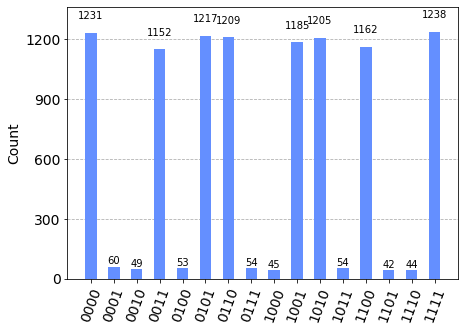

In [84]:
counts_without_hadamard = backend.run(qc_without_hadamard,shots=10000).result().get_counts()
plot_histogram(counts_without_hadamard)

### Our goal is to apply unitary $U$ and $V$ such that the effect noise is reduced by such operation.

Here we only apply $H$ gate

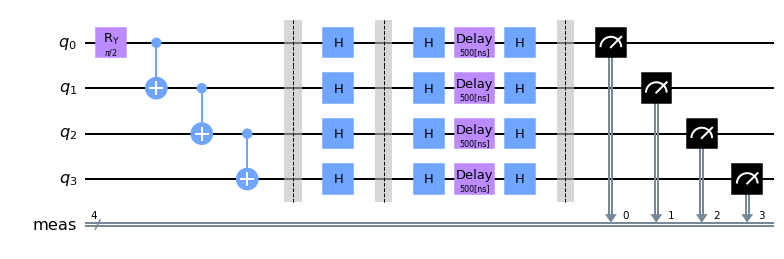

In [85]:
def padded_circuit(n_qubits,theta,delay):
  qc = U_prep(n_qubits,theta)

  for qubit in range(n_qubits):
    qc.h(qubit)
  qc.delay(delay,unit='ns')
  for qubit in range(n_qubits):
    qc.h(qubit)
  qc.measure_all()
  return qc

qc_with_hadamard = padded_circuit(4,pi/2, 500)
qc_with_hadamard.draw('mpl')


## Now measurement with noise

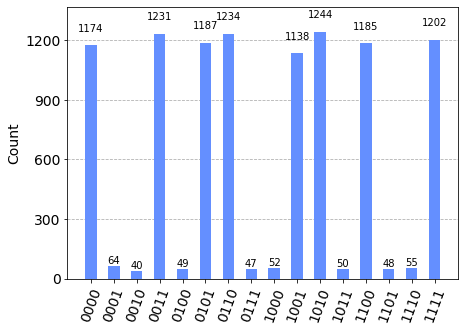

In [86]:
counts_with_hadamard = backend.run(qc_with_hadamard,shots=10000).result().get_counts()
plot_histogram(counts_with_hadamard)

### To measure the amount of noise in all the ways we could pad the circuit, we are defining some simple cost measurement functions:

From analysis of our circuit without any noise, we see the only valid states are 
$|0000⟩\ |0011⟩\ |0101⟩\ |0110⟩\ |1001⟩\ |1010⟩\ |1100⟩\ |1111⟩$

In [87]:
# If state is not in the set of valid states, ouput is erroneous
def cost(counts):
  invalid_states_count = 0
  diff = 0
  counts = dict(counts)
  for state in counts.keys():
    if (state != '0000') and (state != '0011') and (state != '0101') and (state != '0110') and (state != '1001') and (state != '1010') and (state != '1100') and (state != '1111'):
      invalid_states_count += counts[state]
    # probability of getting the other 8 valid states is 1250/10000
    else:
      diff += abs(counts[state]-1250) # we got a valid state but how far is it from the ideal value? i.e deviation from correct value
  total_error = round((invalid_states_count + diff)/10000 , 4 )
  return {'invalid_states_count':invalid_states_count, 'deviation' : diff, 'error':total_error }

In [88]:
# counts = backend.run(qc,shots=10000).result().get_counts()
print(f"Error with noise without hadamard: {cost(counts_without_hadamard)}")
print(f"Error with noise with hadamard: {cost(counts_with_hadamard)}")
print(f"Error without noise: {cost(counts_ideal)}")

Error with noise without hadamard: {'invalid_states_count': 401, 'deviation': 401, 'error': 0.0802}
Error with noise with hadamard: {'invalid_states_count': 405, 'deviation': 405, 'error': 0.081}
Error without noise: {'invalid_states_count': 0, 'deviation': 142, 'error': 0.0142}


We can see that by padding

$U=H$ and $V=H$

has resulted in the reduction of noise

### Now we iterate over all different possible types of gates and calculate their respective errors

In [89]:
# Complete this function
def pad_circuits_with_gates(n_qubits,theta,delay):  
  qc = U_prep(n_qubits,theta)
  range_low, increment = 0, pi/32
  range_high = 2*pi - increment
  circuits = []
 
  
  angle1 = range_low
  while(angle1 <= range_high): # u = rx, v = rx
    angle2 = range_low
    while(angle2 <= range_high):

      qc_pad = qc.copy()

      for qubit in range(n_qubits):     # u = rx
        qc_pad.rx(angle1,qubit)

      qc_pad.delay(delay,unit='ns')

      for qubit in range(n_qubits):     # v = rx
        qc_pad.rx(angle2,qubit)
      
      qc_pad.measure_all()
      circuits.append((qc_pad, angle1,angle2))
      # a1.append(angle1)
      # a2.append(angle2)
      angle2 += increment
    angle1 += increment

  angle1 = range_low
  while(angle1 <= range_high): # u = rx, v = ry
    angle2 = range_low
    while(angle2 <= range_high):

      qc_pad = qc.copy()

      for qubit in range(n_qubits):     # u = rx
        qc_pad.rx(angle1,qubit)

      qc_pad.delay(delay,unit='ns')

      for qubit in range(n_qubits):     # v = ry
        qc_pad.ry(angle2,qubit)
      
      qc_pad.measure_all()
      circuits.append((qc_pad, angle1,angle2))
      # a1.append(angle1)
      # a2.append(angle2)
      angle2 += increment
    angle1 += increment

  angle1 = range_low
  while(angle1 <= range_high): # u = ry, v = rx
    angle2 = range_low
    while(angle2 <= range_high):

      qc_pad = qc.copy()

      for qubit in range(n_qubits):     # u = ry
        qc_pad.ry(angle1,qubit)

      qc_pad.delay(delay,unit='ns')

      for qubit in range(n_qubits):     # v = rx
        qc_pad.rx(angle2,qubit)
      
      qc_pad.measure_all()
      circuits.append((qc_pad, angle1,angle2))
      # a1.append(angle1)
      # a2.append(angle2)
      angle2 += increment
    angle1 += increment

  angle1 = range_low
  while(angle1 <= range_high): # u = ry, v = ry
    angle2 = range_low
    while(angle2 <= range_high):

      qc_pad = qc.copy()

      for qubit in range(n_qubits):     # u = ry
        qc_pad.ry(angle1,qubit)

      qc_pad.delay(delay,unit='ns')

      for qubit in range(n_qubits):     # v = ry
        qc_pad.ry(angle2,qubit)
      
      qc_pad.measure_all()
      circuits.append((qc_pad, angle1,angle2))
      # a1.append(angle1)
      # a2.append(angle2)
      angle2 += increment
    angle1 += increment

  return circuits

ckts = pad_circuits_with_gates(4,pi/2,500)

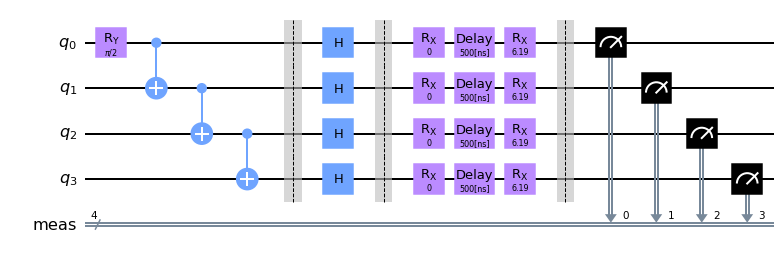

In [90]:
ckts[63][0].draw('mpl')

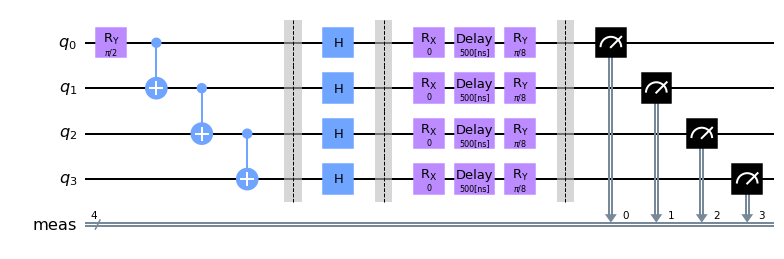

In [91]:
ckts[4100][0].draw('mpl')

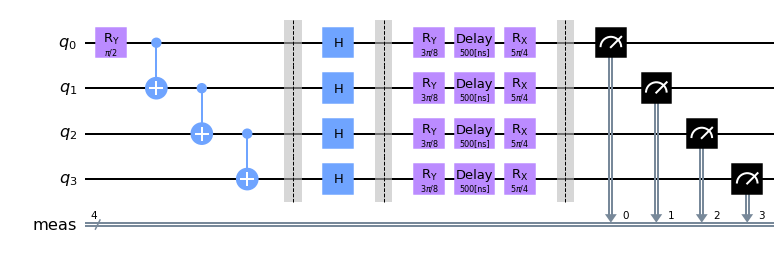

In [92]:
ckts[9000][0].draw('mpl')

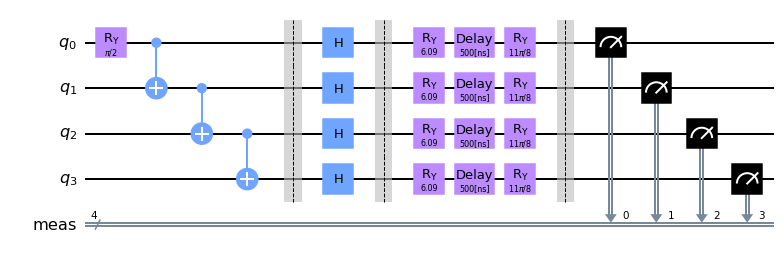

In [93]:
ckts[16300][0].draw('mpl')

### Measuring error for all the circuits and finding the circuit with least error

In [94]:
def getError(ckt_info):
  return ckt_info['error']

In [16]:
from tqdm import tqdm
min_error = 999999
min_err_info = None
min_ckt = None
theta = []
error = []

for ckt in tqdm(range(len(ckts))):
  qc = ckts[ckt][0]
  counts = backend.run(qc,shots=10000).result().get_counts()
  err = cost(counts)
  err['index'] = ckt
  error.append(err)

error.sort(key=getError)


100%|██████████| 16384/16384 [02:13<00:00, 122.58it/s]


In [21]:
print(error[0])

{'invalid_states_count': 334, 'deviation': 346, 'error': 0.068, 'index': 536}


This is the optimal circuit we found

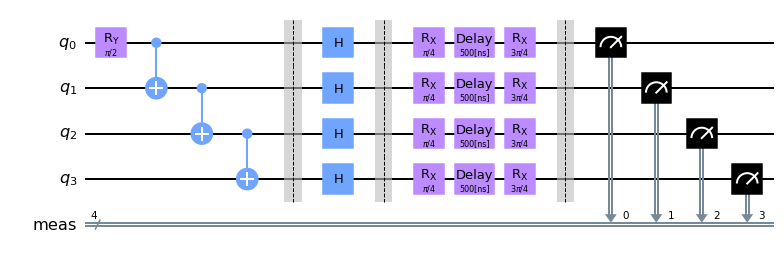

In [22]:
opt_idx = error[0]['index']
min_err_ckt = ckts[opt_idx][0]
min_err_ckt.draw('mpl')

In [181]:
errors = []
for i in range(len(ckts)):
  errors.append(error[i]['error'])

We now plot some interesting results

In [182]:
# for creating a responsive plot
%matplotlib widget

# Seprrating angles of U and V
x = np.array([ckt[:][1] for ckt in ckts ]) # U angle
x = np.array_split(x, len(x) / 4096)

y = np.array([ckt[:][2] for ckt in ckts ]) # V angle
y = np.array_split(y, len(y) / 4096)

z = np.array_split(np.array(errors), len(error)/4096 )


Error without applying any gate {'invalid_states_count': 401, 'deviation': 401, 'error': 0.0802}
Error after applying hadamard gate {'invalid_states_count': 405, 'deviation': 405, 'error': 0.081}
Minimum error we found {'invalid_states_count': 1594, 'deviation': 1594, 'error': 0.3188, 'index': 3734}


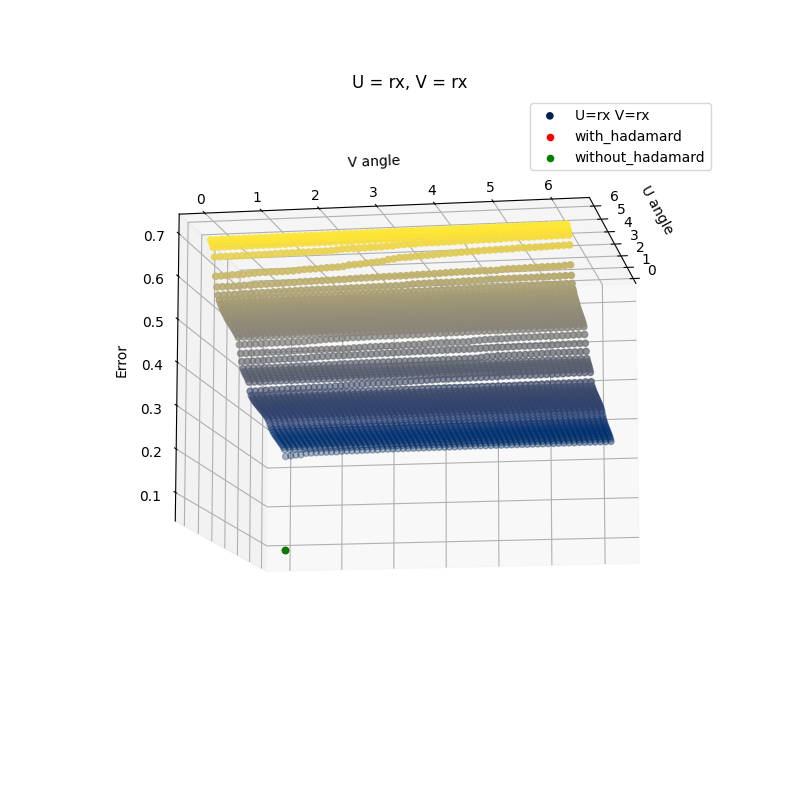

In [183]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.grid()
ax.set_title('U = rx, V = rx')
ax.set_xlabel('U angle')
ax.set_ylabel('V angle')
ax.set_zlabel('Error')

l1 = ax.scatter(x[0], y[0], z[0], c=z[0], cmap='cividis', label='U=rx V=rx')
l2 = ax.scatter(0,0,cost(counts_with_hadamard)['error'], color='red', label='with_hadamard')
l3 = ax.scatter(0,0,cost(counts_without_hadamard)['error'], color='green', label='without_hadamard')
ax.legend(handles=[l1, l2, l3])
ax.view_init(elev=-10, azim=10)

print(f"Error without applying any gate {cost(counts_without_hadamard)}")
print(f"Error after applying hadamard gate {cost(counts_with_hadamard)}")
print(f"Minimum error we found {error[0]}")
plt.show()

Error without applying any gate {'invalid_states_count': 401, 'deviation': 401, 'error': 0.0802}
Error after applying hadamard gate {'invalid_states_count': 405, 'deviation': 405, 'error': 0.081}
Minimum error we found {'invalid_states_count': 1594, 'deviation': 1594, 'error': 0.3188, 'index': 3734}


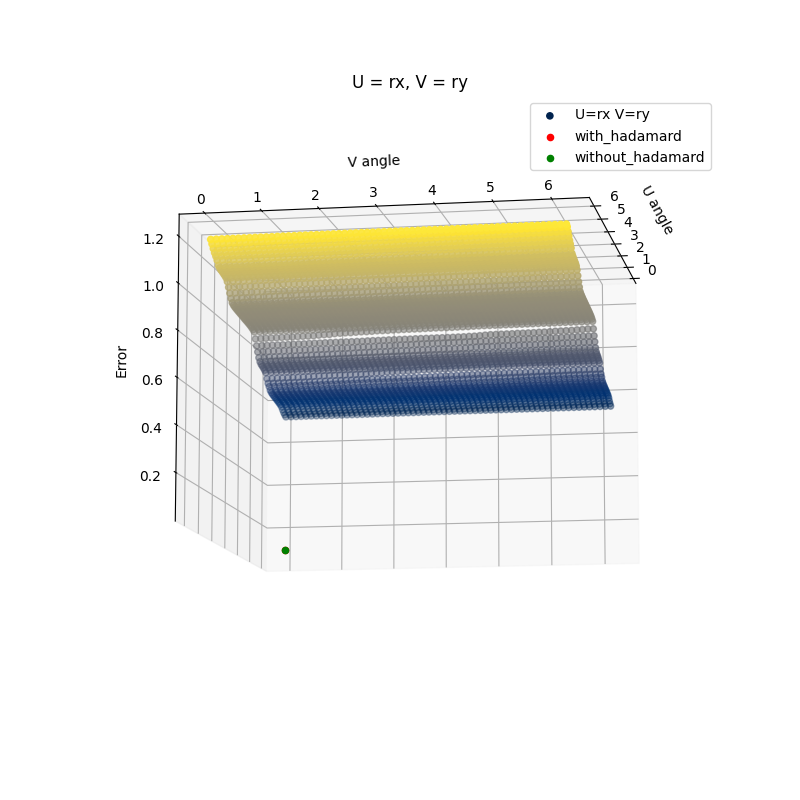

In [184]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.grid()
ax.set_title('U = rx, V = ry')
ax.set_xlabel('U angle')
ax.set_ylabel('V angle')
ax.set_zlabel('Error')

l1 = ax.scatter(x[1], y[1], z[1], c=z[1], cmap='cividis', label='U=rx V=ry')
l2 = ax.scatter(0,0,cost(counts_with_hadamard)['error'], color='red', label='with_hadamard')
l3 = ax.scatter(0,0,cost(counts_without_hadamard)['error'], color='green', label='without_hadamard')
ax.legend(handles=[l1, l2, l3])
ax.view_init(elev=-10, azim=10)
print(f"Error without applying any gate {cost(counts_without_hadamard)}")
print(f"Error after applying hadamard gate {cost(counts_with_hadamard)}")
print(f"Minimum error we found {error[0]}")
plt.show()

Error without applying any gate {'invalid_states_count': 401, 'deviation': 401, 'error': 0.0802}
Error after applying hadamard gate {'invalid_states_count': 405, 'deviation': 405, 'error': 0.081}
Minimum error we found with U=ry V=rx {'invalid_states_count': 1594, 'deviation': 1594, 'error': 0.3188, 'index': 3734}


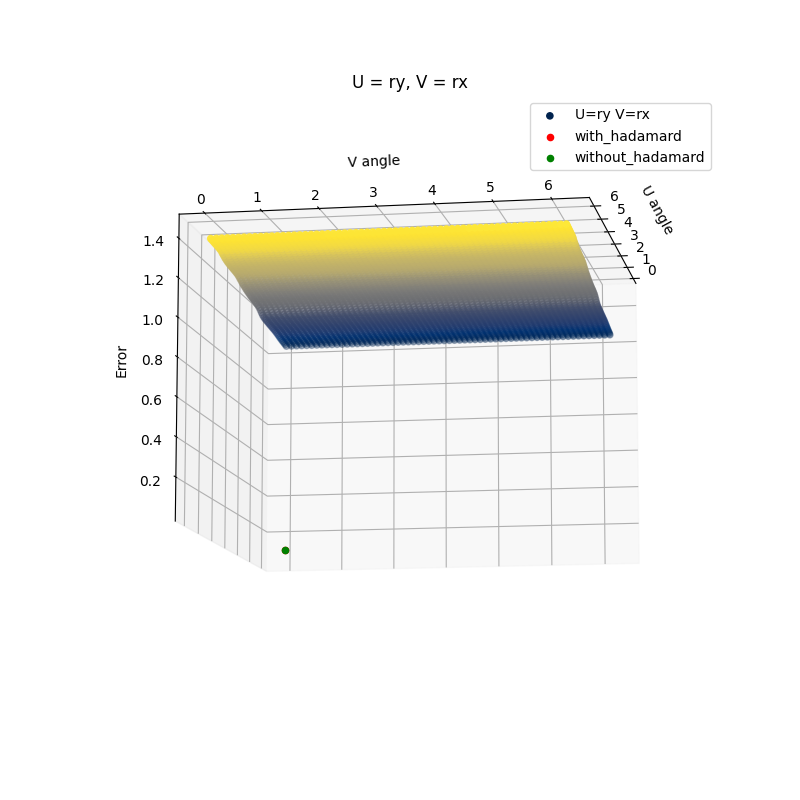

In [185]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.grid()
ax.set_title('U = ry, V = rx')
ax.set_xlabel('U angle')
ax.set_ylabel('V angle')
ax.set_zlabel('Error')

l1 = ax.scatter(x[2], y[2], z[2], c=z[2], cmap='cividis', label='U=ry V=rx')
l2 = ax.scatter(0,0,cost(counts_with_hadamard)['error'], color='red', label='with_hadamard')
l3 = ax.scatter(0,0,cost(counts_without_hadamard)['error'], color='green', label='without_hadamard')
ax.legend(handles=[l1, l2, l3])
ax.view_init(elev=-10, azim=10)
print(f"Error without applying any gate {cost(counts_without_hadamard)}")
print(f"Error after applying hadamard gate {cost(counts_with_hadamard)}")
print(f"Minimum error we found with U=ry V=rx {error[0]}")
plt.show()

Error without applying any gate {'invalid_states_count': 401, 'deviation': 401, 'error': 0.0802}
Error after applying hadamard gate {'invalid_states_count': 405, 'deviation': 405, 'error': 0.081}
Minimum error we found with U=ry V=rx {'invalid_states_count': 1594, 'deviation': 1594, 'error': 0.3188, 'index': 3734}


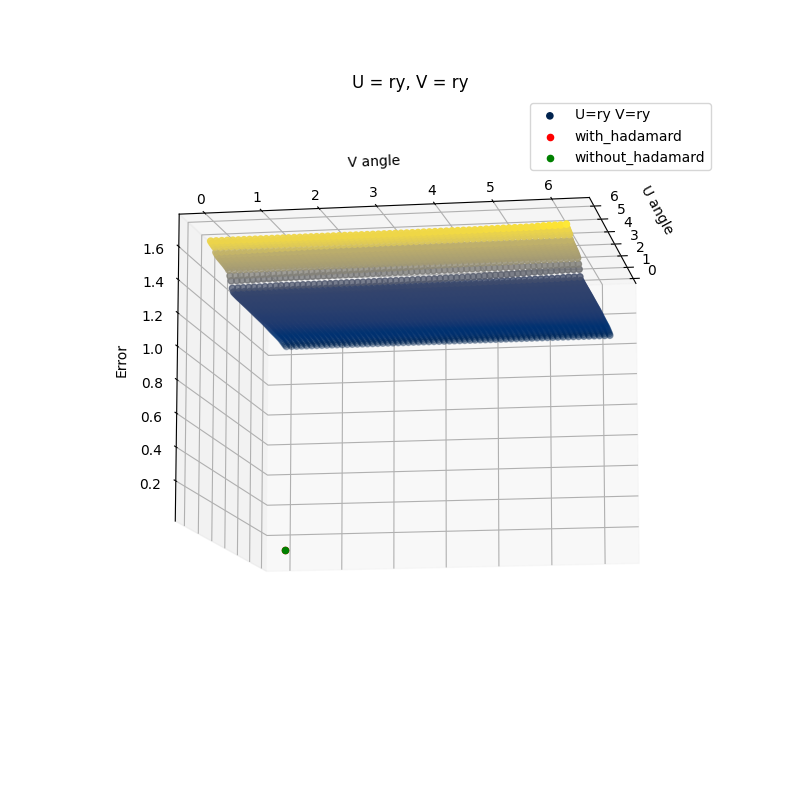

In [186]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.grid()
ax.set_title('U = ry, V = ry')
ax.set_xlabel('U angle')
ax.set_ylabel('V angle')
ax.set_zlabel('Error')

l1 = ax.scatter(x[3], y[3], z[3], c=z[3], cmap='cividis', label='U=ry V=ry')
l2 = ax.scatter(0,0,cost(counts_with_hadamard)['error'], color='red', label='with_hadamard')
l3 = ax.scatter(0,0,cost(counts_without_hadamard)['error'], color='green', label='without_hadamard')
ax.legend(handles=[l1, l2, l3])
ax.view_init(elev=-10, azim=10)
print(f"Error without applying any gate {cost(counts_without_hadamard)}")
print(f"Error after applying hadamard gate {cost(counts_with_hadamard)}")
print(f"Minimum error we found with U=ry V=rx {error[0]}")
plt.show()

## Now we wish to change the noise model

In [10]:
from depolarization_template import depolarize as dp
x, y, z, ckts, error, opt_idx, min_err_ckt = dp(noise_prob=0.03,delay_time=500)

100%|██████████| 16384/16384 [02:15<00:00, 121.00it/s]


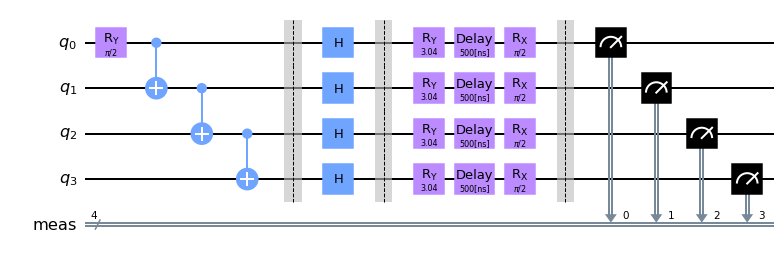

In [11]:
min_err_ckt.draw('mpl')

In [12]:
print(error[0])

{'invalid_states_count': 507, 'deviation': 507, 'error': 0.1014, 'index': 10192}


## And we run our optimal circuit with different levels of noise and delay

In [14]:
from tqdm import tqdm
x_list = []
y_list = []
z_list = []
ckts_list = []
error_list = []
opt_idx_list = []
min_err_ckt_list = []

for delay in tqdm(range(500,1200,100)):
  noise_prob = 0.04
  while(noise_prob<0.1):
    x, y, z, ckts, error, opt_idx, min_err_ckt = dp(noise_prob,delay)
    x_list.append(x)
    y_list.append(y)
    z_list.append(z)
    ckts_list.append(ckts)
    error_list.append(error)
    opt_idx_list.append(opt_idx)
    min_err_ckt_list.append(min_err_ckt)
    noise_prob += 0.01

100%|██████████| 7/7 [2:35:11<00:00, 1330.24s/it]


Uncomment the lines below to save progress. Be careful the file may be large

In [18]:

# import pickle
# data = {
# 'x':x_list,
# 'y':y_list,
# 'z':z_list,
# 'ckts': ckts_list,
# 'errors':error_list,
# 'opt_idx':opt_idx_list,
# 'mini_err_ckt':min_err_ckt_list
# }

# with open("depolarization.pkl", "wb") as file:
#     pickle.dump(data, file)

Error after Fixing *delay*, changing error probability $p$

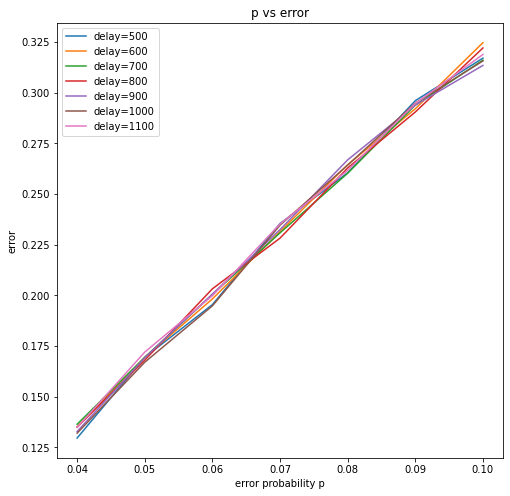

In [150]:
fig, ax = plt.subplots(figsize=(8,8))

l1 = ax.plot([0.04,0.05,0.06,0.07,0.08,0.09,0.1], [z_list[0][0][0],z_list[1][0][0],z_list[2][0][0],z_list[3][0][0],z_list[4][0][0],z_list[5][0][0],z_list[6][0][0]])
l2 = ax.plot([0.04,0.05,0.06,0.07,0.08,0.09,0.1], [z_list[7][0][0],z_list[8][0][0],z_list[9][0][0],z_list[10][0][0],z_list[11][0][0],z_list[12][0][0],z_list[13][0][0]])
l3 = ax.plot([0.04,0.05,0.06,0.07,0.08,0.09,0.1], [z_list[14][0][0],z_list[15][0][0],z_list[16][0][0],z_list[17][0][0],z_list[18][0][0],z_list[19][0][0],z_list[20][0][0]])
l4 = ax.plot([0.04,0.05,0.06,0.07,0.08,0.09,0.1], [z_list[21][0][0],z_list[22][0][0],z_list[23][0][0],z_list[24][0][0],z_list[25][0][0],z_list[26][0][0],z_list[27][0][0]])

l5 = ax.plot([0.04,0.05,0.06,0.07,0.08,0.09,0.1], [z_list[28][0][0],z_list[29][0][0],z_list[30][0][0],z_list[31][0][0],z_list[32][0][0],z_list[33][0][0],z_list[34][0][0]])
l6 = ax.plot([0.04,0.05,0.06,0.07,0.08,0.09,0.1], [z_list[35][0][0],z_list[36][0][0],z_list[37][0][0],z_list[38][0][0],z_list[39][0][0],z_list[40][0][0],z_list[41][0][0]])
l7 = ax.plot([0.04,0.05,0.06,0.07,0.08,0.09,0.1], [z_list[42][0][0],z_list[43][0][0],z_list[44][0][0],z_list[45][0][0],z_list[46][0][0],z_list[47][0][0],z_list[48][0][0]])
ax.legend(['delay=500','delay=600','delay=700','delay=800','delay=900','delay=1000','delay=1100'])
ax.set_xlabel('error probability p')
ax.set_ylabel('error')
ax.set_title('p vs error')
plt.show()

In [160]:
z_list[14][0][0]

0.1364

Error after fixing error probability *p*, changing delay 

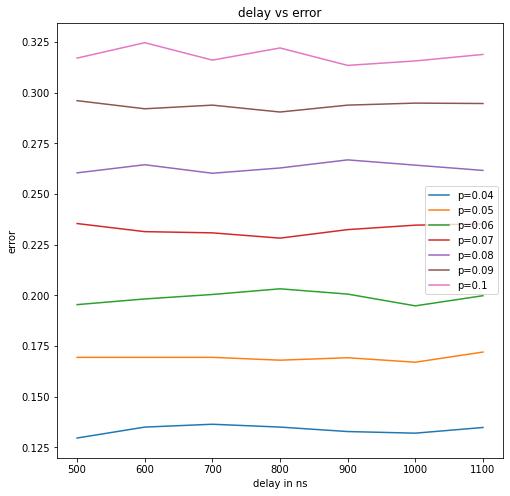

In [162]:
fig, ax = plt.subplots(figsize=(8,8))

l1 = ax.plot([500,600,700,800,900,1000,1100], [z_list[0][0][0],z_list[7][0][0],z_list[14][0][0],z_list[21][0][0],z_list[28][0][0],z_list[35][0][0],z_list[42][0][0]])
l2 = ax.plot([500,600,700,800,900,1000,1100], [z_list[1][0][0],z_list[8][0][0],z_list[15][0][0],z_list[22][0][0],z_list[29][0][0],z_list[36][0][0],z_list[43][0][0]])
l3 = ax.plot([500,600,700,800,900,1000,1100], [z_list[2][0][0],z_list[9][0][0],z_list[16][0][0],z_list[23][0][0],z_list[30][0][0],z_list[37][0][0],z_list[44][0][0]])
l4 = ax.plot([500,600,700,800,900,1000,1100], [z_list[3][0][0],z_list[10][0][0],z_list[17][0][0],z_list[24][0][0],z_list[31][0][0],z_list[38][0][0],z_list[45][0][0]])

l5 = ax.plot([500,600,700,800,900,1000,1100], [z_list[4][0][0],z_list[11][0][0],z_list[18][0][0],z_list[25][0][0],z_list[32][0][0],z_list[39][0][0],z_list[46][0][0]])
l6 = ax.plot([500,600,700,800,900,1000,1100], [z_list[5][0][0],z_list[12][0][0],z_list[19][0][0],z_list[26][0][0],z_list[33][0][0],z_list[40][0][0],z_list[47][0][0]])
l7 = ax.plot([500,600,700,800,900,1000,1100], [z_list[6][0][0],z_list[13][0][0],z_list[20][0][0],z_list[27][0][0],z_list[34][0][0],z_list[41][0][0],z_list[48][0][0]])
ax.legend(['p=0.04','p=0.05','p=0.06','p=0.07','p=0.08','p=0.09','p=0.1'])
ax.set_xlabel('delay in ns')
ax.set_ylabel('error')
ax.set_title('delay vs error')
plt.show()

## Plotting some of the best circuits

In [165]:
len(min_err_ckt_list) ## For each delay, and each error probability

49

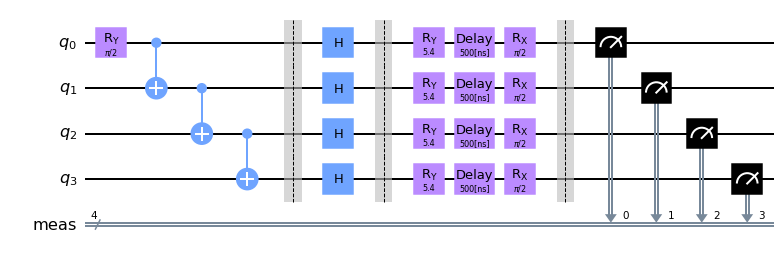

In [170]:
min_err_ckt_list[0].draw('mpl')

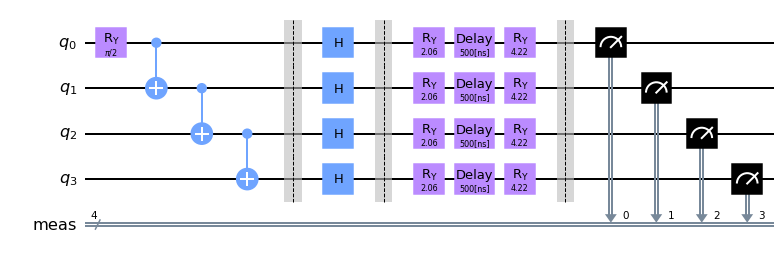

In [171]:
min_err_ckt_list[1].draw('mpl')

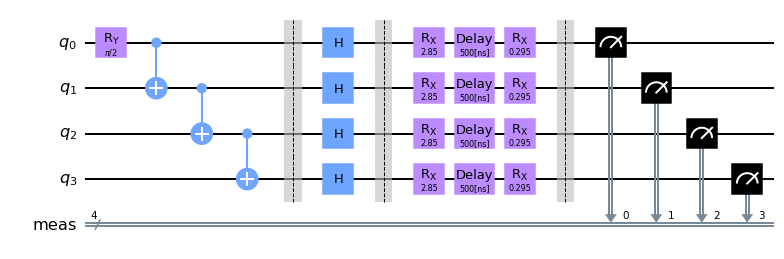

In [172]:
min_err_ckt_list[3].draw('mpl')

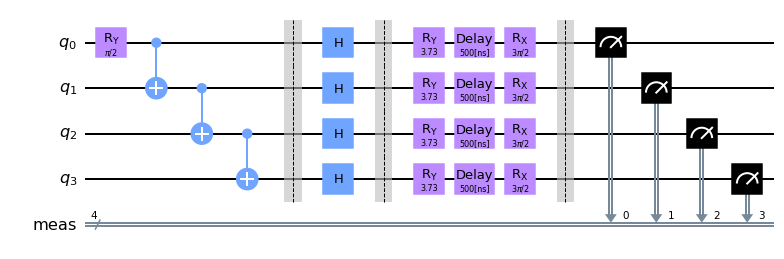

In [173]:
min_err_ckt_list[4].draw('mpl')

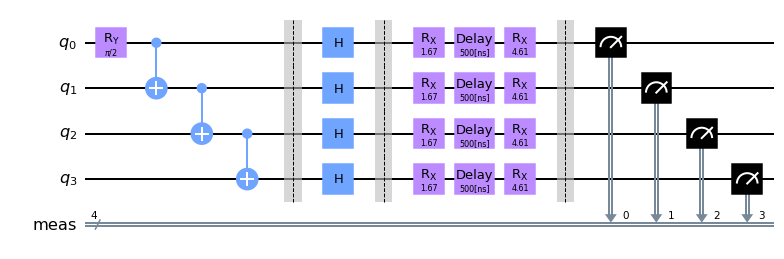

In [174]:
min_err_ckt_list[5].draw('mpl')

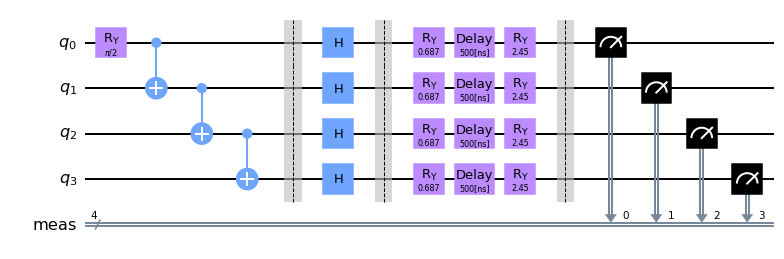

In [175]:
min_err_ckt_list[6].draw('mpl')

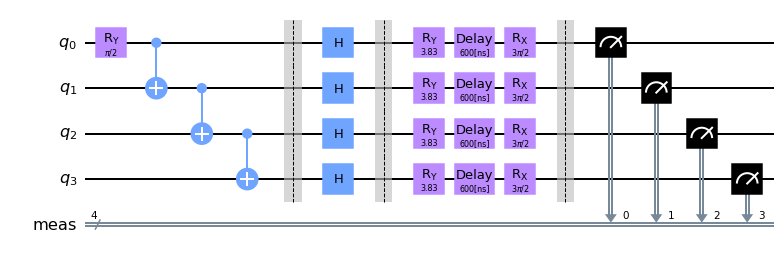

In [176]:
min_err_ckt_list[7].draw('mpl')

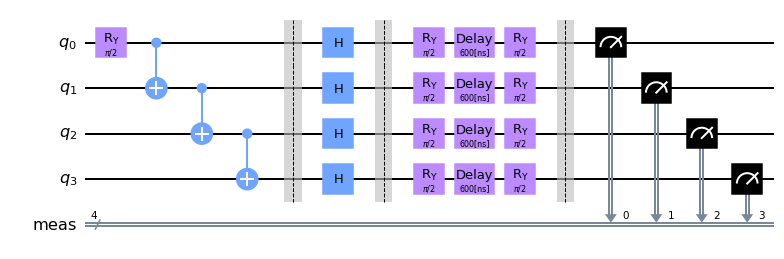

In [177]:
min_err_ckt_list[8].draw('mpl')

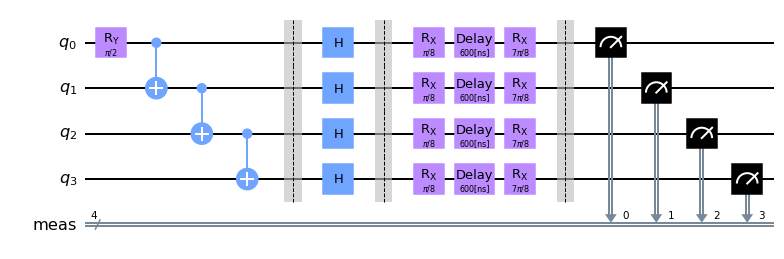

In [178]:
min_err_ckt_list[9].draw('mpl')

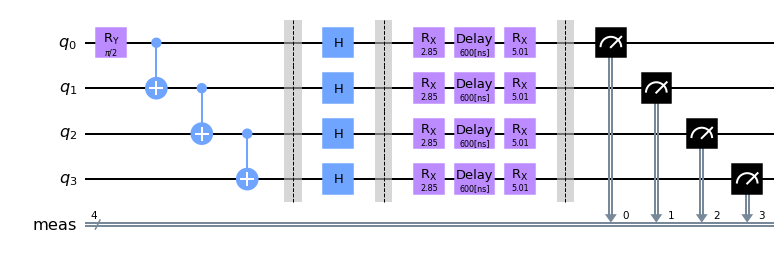

In [179]:
min_err_ckt_list[10].draw('mpl')

In [180]:
%qiskit_version_table